In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from dotmap import DotMap

In [7]:
PROJECT_PATH = '../'
DATA_DIR = "/home/swei20/AE/data/"
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
NORM_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/norm/spectra.h5'

sys.path.insert(0, PROJECT_PATH)

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
import tensorflow as tf
# tf.enable_v2_behavior()
gpus = tf.config.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load data

In [11]:
with h5py.File(NORM_PATH, 'r') as f:
    flux = f['flux'][()]
    mask = f['flux_idx'][()]

    wave = f['wave'][()]
#     eigv = f['flux_eigv'][()]

In [123]:
para = pd.DataFrame(data=np.transpose(np.where(mask)), columns=["F","T","L","C","O"])

In [128]:
id_test = para[(para["C"] == 3) & (para["O"] == 1)].index

In [133]:
para.iloc[id_test]

,F,T,L,C,O
9,0,0,0,3,1
29,0,0,1,3,1
49,0,0,2,3,1
69,0,0,3,3,1
85,0,0,4,3,1
...,...,...,...,...,...
38341,13,12,6,3,1
38361,13,12,7,3,1
38381,13,12,8,3,1
38401,13,12,9,3,1


In [12]:
flux0 = flux[mask]

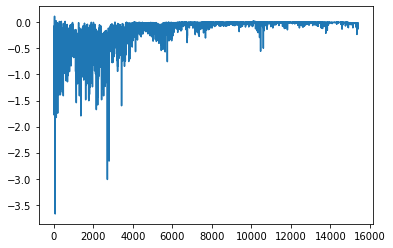

In [13]:
plt.plot(flux0[0])

Robust PCA

In [15]:
def get_flux_in_Wrange(flux, wave, Ws):
    start = np.digitize(Ws[0], wave)
    end = np.digitize(Ws[1], wave)
    return flux[..., start:end], wave[start:end]

In [16]:
flux1, wave1 = get_flux_in_Wrange(flux0, wave, [3800, 13000])

In [95]:
flux2 = np.clip(-flux1, 0, None)

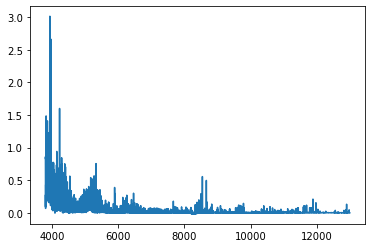

In [19]:
plt.plot(wave1, flux2[0])

In [20]:
m, n = flux2.shape

In [139]:
from lv.rpca_v1 import rpcaADMM

In [113]:
wave1

array([ 3800.3757,  3800.7556,  3801.1357, ..., 12996.7305, 12998.0312,
       12999.3311])

In [153]:
flux_test, wave_test = get_flux_in_Wrange(flux2, wave1, [6500, 9800])

In [136]:
flux_test00 = flux_test[id_test]

In [137]:
flux_test00.shape

(1936, 1484)

In [154]:
flux_test.shape

(38432, 4105)

In [ ]:
h = rpcaADMM(flux_test, parallel=0)

38432 4105


  0%|          | 0/100 [00:00<?, ?it/s]


iter	    r norm	   eps pri	    s norm	  eps dual	      loss


  1%|          | 1/100 [01:40<2:45:52, 100.53s/it]

   1	  909.3922	   13.4470	 1127.1486	   12.8851	 168794.49


 10%|█         | 10/100 [17:42<2:38:23, 105.59s/it]

  10	  644.8647	   32.0016	 1449.8649	   43.2563	6157486.89


 20%|██        | 20/100 [35:46<2:21:52, 106.40s/it]

  20	 1065.3002	   31.1385	 2281.2392	   39.2118	5097346.79


 30%|███       | 30/100 [54:05<2:06:10, 108.15s/it]

  30	  866.7198	   31.6257	 2178.5952	   39.0803	5225093.20


 40%|████      | 40/100 [1:12:10<1:47:34, 107.58s/it]

  40	 1046.0658	   29.9841	 1859.4397	   41.3952	5225881.72


 50%|█████     | 50/100 [1:29:47<1:26:43, 104.06s/it]

  50	  998.1770	   30.7322	 1222.1558	   39.2302	4915036.54


 60%|██████    | 60/100 [1:48:25<1:14:08, 111.21s/it]

  60	  986.2787	   31.3632	 2131.6012	   39.0172	5195744.54


 64%|██████▍   | 64/100 [1:55:51<1:06:01, 110.03s/it]

In [145]:
h["R_admm"].shape

(1936, 1484)

In [ ]:
def step(ep, *args):
    a,b,c,d = args
    print(a,b,c,d)
    print(ep)

In [150]:
np.where(h["S_admm"]!=0)

(array([], dtype=int64), array([], dtype=int64))

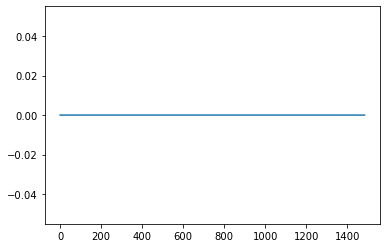

In [148]:
plt.plot(np.sum(h["S_admm"], axis=0))